# **LIBRERIAS Y HERRAMIENTAS**

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use("ggplot")
%matplotlib inline
plt.rcParams.update({'font.size': 22})

#from tqdm import tqdm_notebook, tnrange
from tqdm import notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.metrics import BinaryIoU
import tensorflow.keras.metrics

from tensorflow.keras.applications.vgg16 import VGG16 as PreModel
from collections import defaultdict, OrderedDict

from keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, UpSampling2D, BatchNormalization, Activation, Cropping2D, ZeroPadding2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/bea/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-04-16 11:06:43.282809: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 11:06:43.310632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 11

In [2]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.16.1


2024-04-16 11:06:44.077423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 11:06:44.082265: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

# Dataset

In [3]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [4]:
im_width = 320
im_height = 320
border = 5
idsimag = next(os.walk("datacubes/tabuyo/2023/pngs/mini_v3"))[2]

# La mascara es la misma para todas las imagenes
mask_path = 'datacubes/tabuyo/2023/mask_testing/mini_mascara_2023.png'
mask = img_to_array(load_img(mask_path))
mask = resize(mask, (im_height, im_width, 4), mode = 'constant', preserve_range = True)

x = np.zeros((len(idsimag), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(idsimag), im_height, im_width, 4), dtype=np.float32)

for n, id_ in notebook.tqdm(enumerate(idsimag), total=len(idsimag)):
    img = load_img("datacubes/tabuyo/2023/pngs/mini_v3/"+id_, color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_height, im_width, 3), mode = 'constant', preserve_range = True) #Cambiado las dimensiones para coincidir con VGG16

    x[n] = x_img/255.0
    y[n] = mask/255.0

  0%|          | 0/51 [00:00<?, ?it/s]

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
y_train[0]

array([[[0.7179011 , 0.8204585 , 0.8204585 , 0.7179011 ],
        [0.80060077, 0.9149723 , 0.9149723 , 0.80060077],
        [0.8006447 , 0.9150225 , 0.9150225 , 0.8006447 ],
        ...,
        [0.8006447 , 0.9150225 , 0.9150225 , 0.8006447 ],
        [0.80060077, 0.9149723 , 0.9149723 , 0.80060077],
        [0.7179011 , 0.8204585 , 0.8204585 , 0.7179011 ]],

       [[0.7845516 , 0.89663047, 0.89663047, 0.7845516 ],
        [0.8749292 , 0.9999191 , 0.9999191 , 0.8749292 ],
        [0.87497723, 0.99997395, 0.99997395, 0.87497723],
        ...,
        [0.87497723, 0.99997395, 0.99997395, 0.87497723],
        [0.8749292 , 0.9999191 , 0.9999191 , 0.8749292 ],
        [0.7845516 , 0.89663047, 0.89663047, 0.7845516 ]],

       [[0.78457206, 0.8966538 , 0.8966538 , 0.78457206],
        [0.87495196, 0.9999451 , 0.9999451 , 0.87495196],
        [0.875     , 1.        , 1.        , 0.875     ],
        ...,
        [0.875     , 1.        , 1.        , 0.875     ],
        [0.87495196, 0.999945

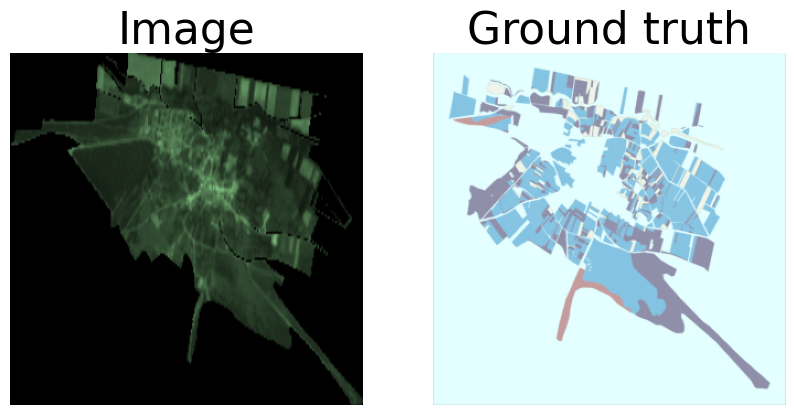

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(x_train[0])
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(y_train[0])
axes[1].set_title('Ground truth')
axes[1].axis('off')

plt.show()

In [8]:
train_gen = DataGenerator(x_train, y_train, 4)
test_gen = DataGenerator(x_valid, y_valid, 4)

# Modelo U-NET+VGG16

In [9]:
def conv_block(input, n_filters, kernel_size = 3,batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

#Metodo de creación de bloque de expansión

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = PreModel(include_top=False, weights="imagenet", input_tensor=inputs)
    vgg16.trainable = False
    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(4, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [11]:
EPOCHS = 10

model = build_vgg16_unet((im_width, im_height, 3))
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=4)])

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet_vgg16.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [12]:
history = model.fit(train_gen, epochs=EPOCHS, callbacks=callbacks, validation_data=test_gen)

Epoch 1/10


/home/bea/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4886 - loss: 5.1912 - mean_io_u: 0.3374
Epoch 1: val_loss improved from inf to 143.79529, saving model to model-unet_vgg16.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.4884 - loss: 5.1802 - mean_io_u: 0.3374 - val_accuracy: 0.4084 - val_loss: 143.7953 - val_mean_io_u: 0.3904 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5687 - loss: 4.8870 - mean_io_u: 0.3374
Epoch 2: val_loss did not improve from 143.79529
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5670 - loss: 4.8868 - mean_io_u: 0.3374 - val_accuracy: 0.2299 - val_loss: 494.2852 - val_mean_io_u: 0.4350 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5647 - loss: 4.8837 - mean_io_u: 0.3374
Epoch 3: val_loss did not improve from 143.79529
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5624 - loss: 4.8830 - mean_io_u: 0.3374 - val_accuracy: 0.1108 - val_loss: 192.2468 - v

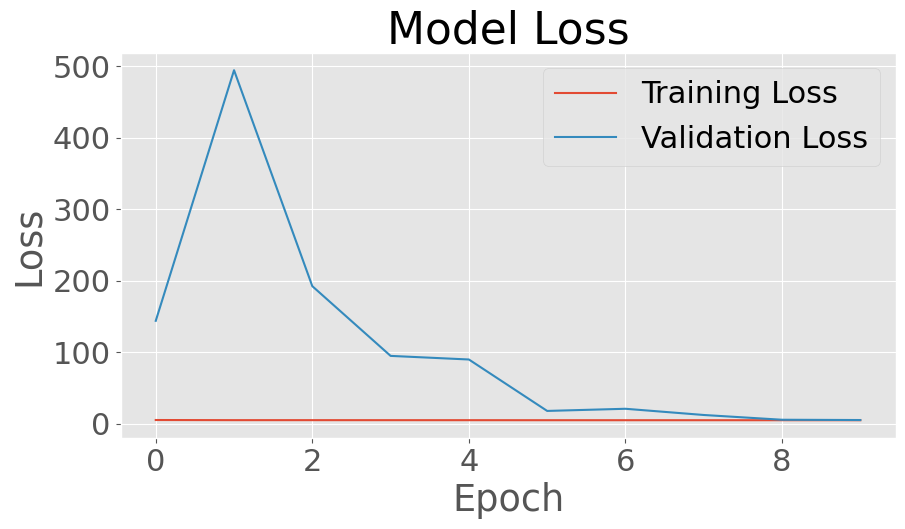

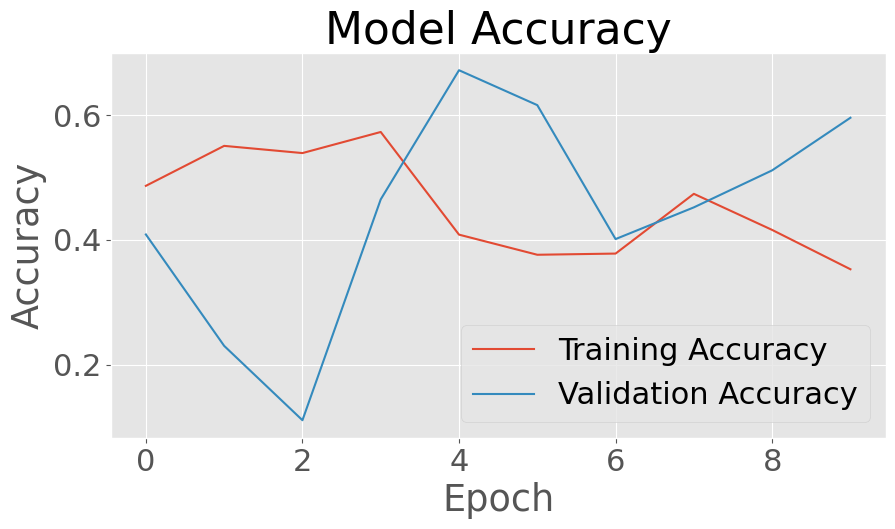

In [13]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# **PREDICCION MODELO ACCURACY**


In [14]:
model.load_weights('model-unet_vgg16.weights.h5')

In [15]:
model.evaluate(x_valid, y_valid, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5954 - loss: 5.0499 - mean_io_u: 0.3374


[5.049948692321777, 0.595405638217926, 0.33738014101982117]

In [16]:
preds_train_acc = (model.predict(x_train, verbose=1)> 0.5).astype(np.uint8)
preds_val_acc= (model.predict(x_valid, verbose=1)> 0.5).astype(np.float32)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [17]:
preds_val_acc[0]

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

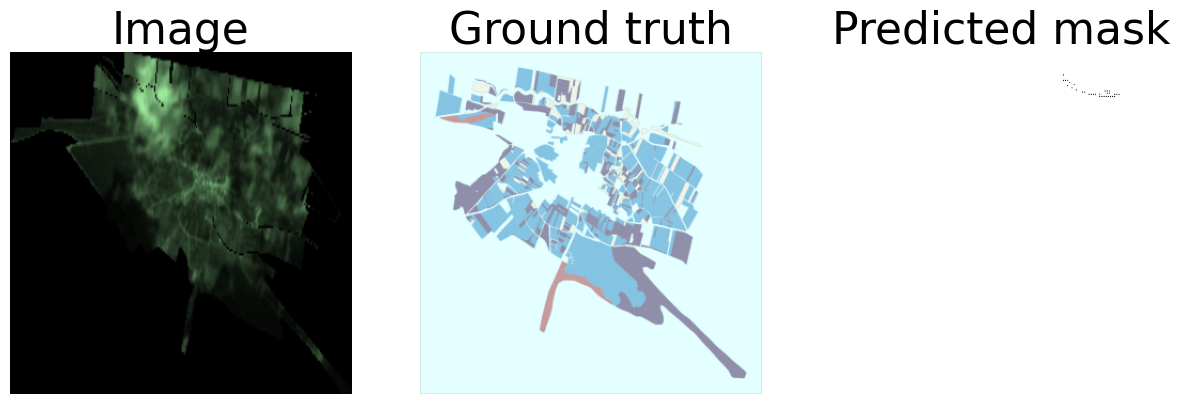

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(x_valid[0])
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(y_valid[0])
axes[1].set_title('Ground truth')
axes[1].axis('off')


axes[2].imshow(preds_val_acc[0])
axes[2].set_title('Predicted mask')
axes[2].axis('off')

plt.show()
